[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['NVDA']: Exception('%ticker%: 1m data not available for startTime=1710216000 and endTime=1710820800. The requested range must be within the last 30 days.')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


No data available for plotting in this chunk.


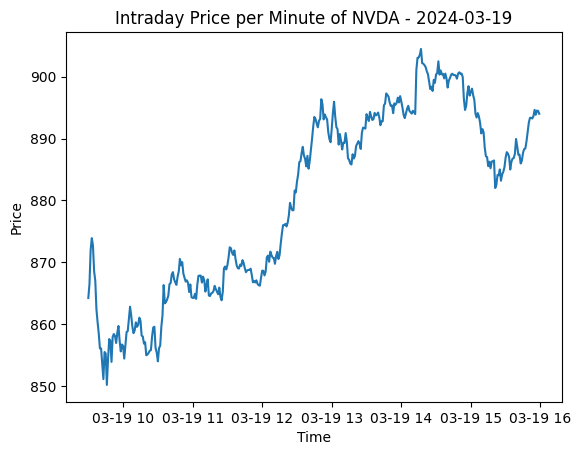

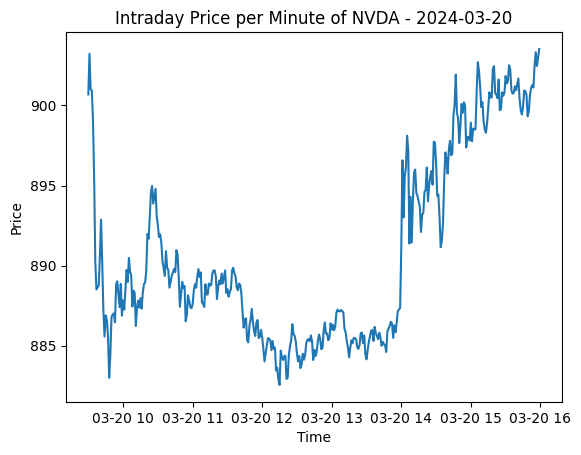

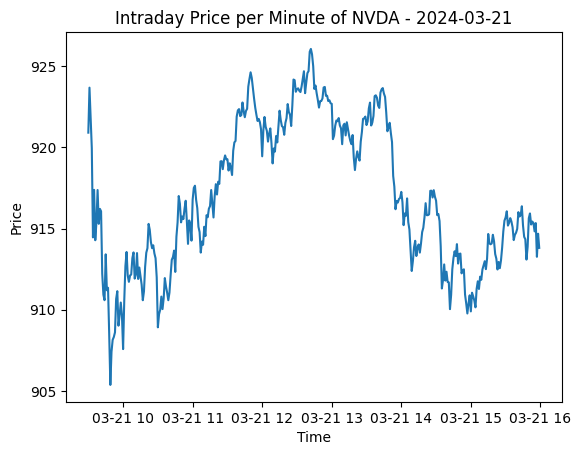

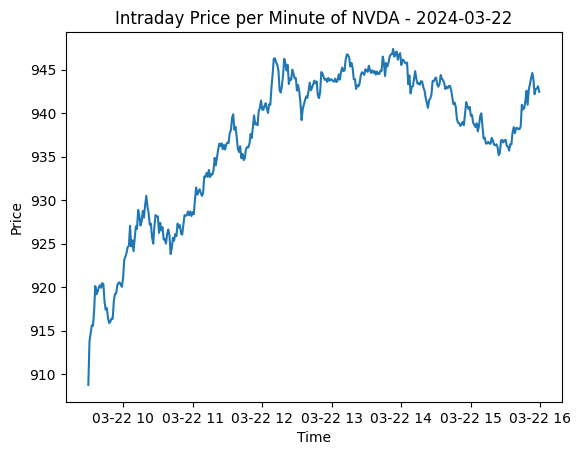

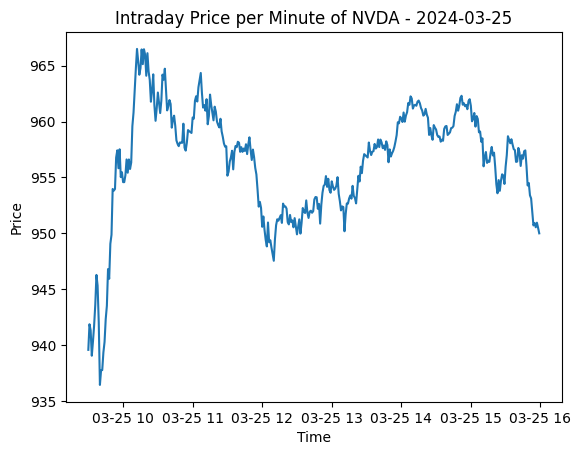

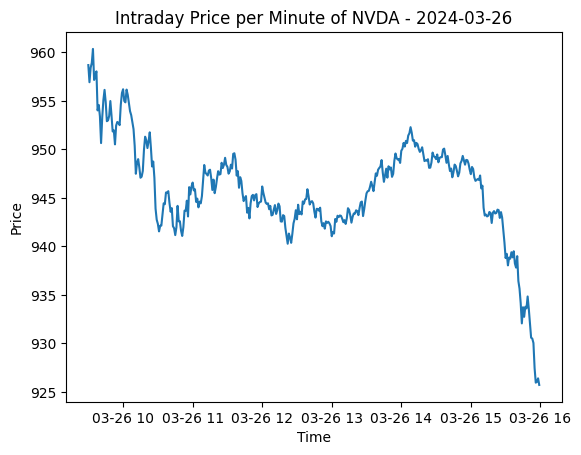

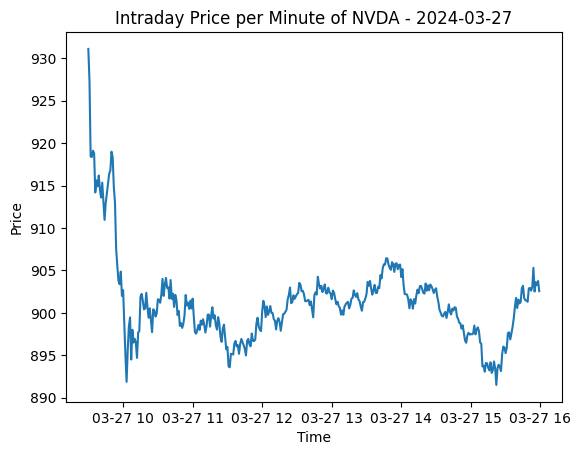

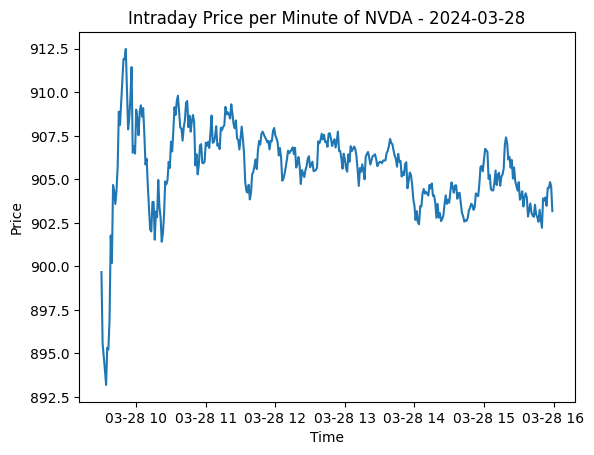

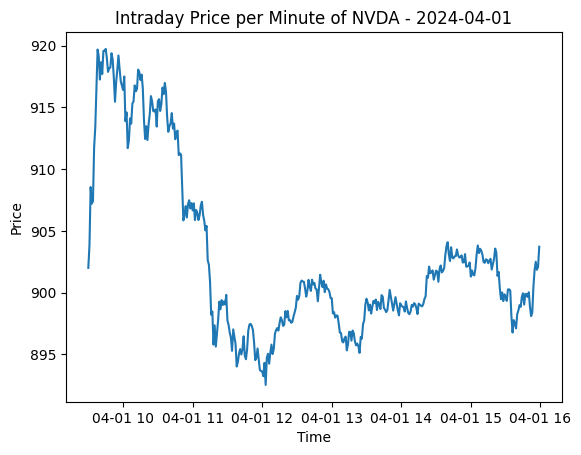

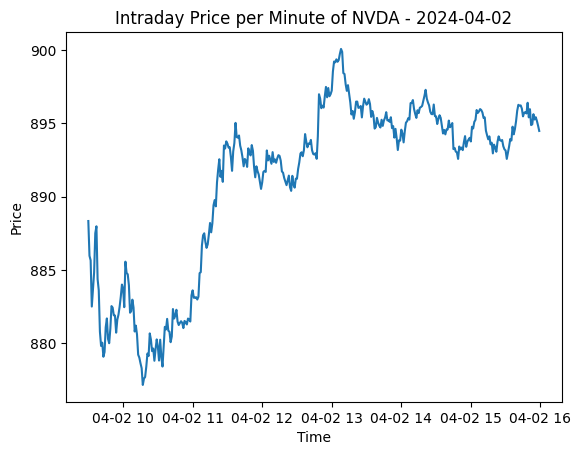

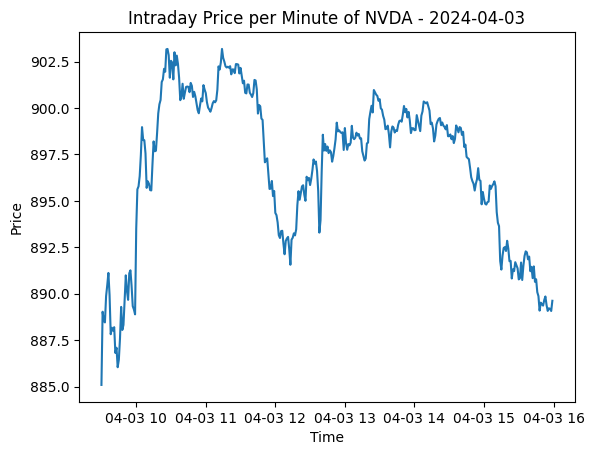

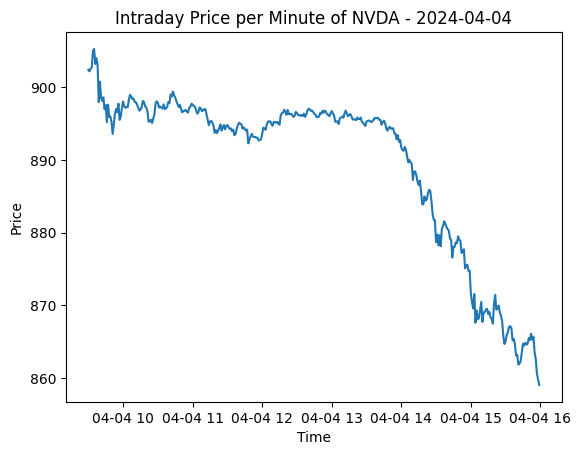

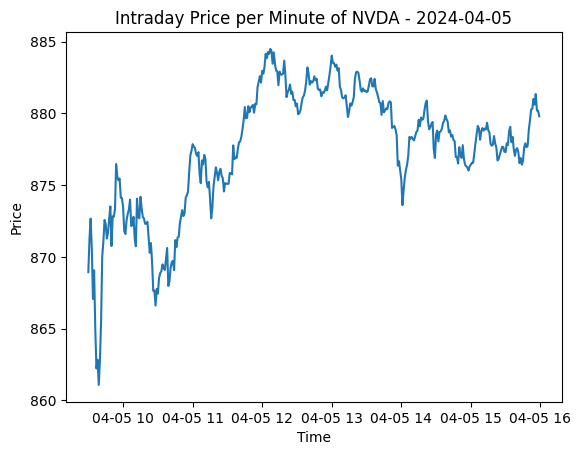

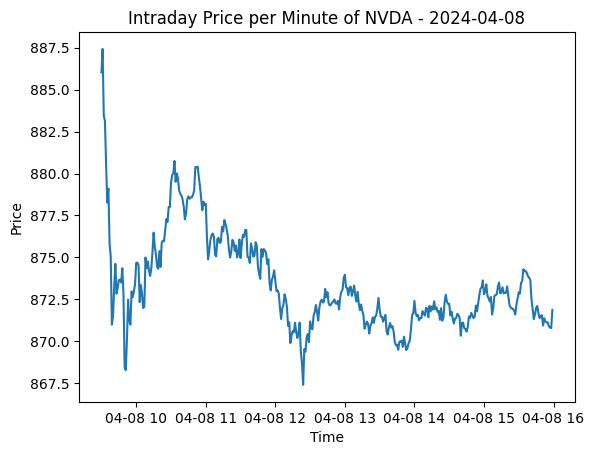

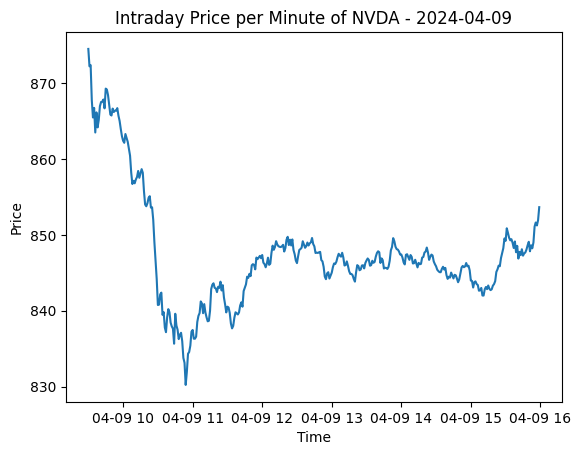

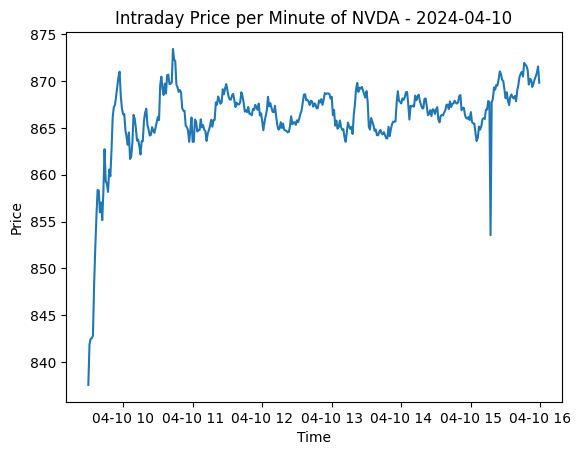

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to fetch intraday data for a given date range
def fetch_intraday_data(ticker_symbol, start_date, end_date):
    try:
        return yf.download(ticker_symbol, start=start_date, end=end_date, interval="1m")
    except Exception as e:
        print(f"Failed to download data for {ticker_symbol}: {e}")
        return None

# Define the ticker symbol and date range
ticker_symbol = "NVDA"
end_date = datetime.now().date()
start_date = end_date - timedelta(days=30)

# Initialize a list to store stock data chunks
stock_data_chunks = []

# Download intraday data in chunks of 7 days
while start_date < end_date:
    next_date = start_date + timedelta(days=7)
    if next_date > end_date:
        next_date = end_date
    stock_data_chunk = fetch_intraday_data(ticker_symbol, start_date, next_date)
    if stock_data_chunk is not None:
        stock_data_chunks.append(stock_data_chunk)
    start_date = next_date

# Plot intraday price per minute for each day within each chunk
for stock_data_chunk in stock_data_chunks:
    
    if not stock_data_chunk.empty:
        for day, data in stock_data_chunk.groupby(stock_data_chunk.index.date):
            plt.figure()
            plt.plot(data.index, data["Close"])
            plt.xlabel("Time")
            plt.ylabel("Price")
            plt.title("Intraday Price per Minute of " + ticker_symbol + " - " + str(day))
            plt.show()
    else:
        print(f"No data available for plotting in this chunk.")


In [14]:
import boto3
from botocore.config import Config

# Initialize a session using your credentials
session = boto3.Session(
   aws_access_key_id='fcfedc12-19c7-4283-89b4-3d6144865bf5',
   aws_secret_access_key='DTc8n47jA_nApfGqD4aqKv9ntIHFOj0U',
)

# Create a client with your session and specify the endpoint
s3 = session.client(
   's3',
   endpoint_url='https://files.polygon.io',
   config=Config(signature_version='s3v4'),
)

# List Example
# Initialize a paginator for listing objects
paginator = s3.get_paginator('list_objects_v2')

# Choose the appropriate prefix depending on the data you need:
# - 'global_crypto' for global cryptocurrency data
# - 'global_forex' for global forex data
# - 'us_indices' for US indices data
# - 'us_options_opra' for US options (OPRA) data
# - 'us_stocks_sip' for US stocks (SIP) data
prefix = 'us_stocks_sip'  # Example: Change this prefix to match your data need

# List objects using the selected prefix
print("List of files:")
res = []
for page in paginator.paginate(Bucket='flatfiles', Prefix=prefix):
    for obj in page['Contents']:
        # print(obj['Key'])
        res.append(obj['Key'])


List of files:
20656


In [39]:
aws s3 ls s3://flatfiles/us_stocks_sip/minute_aggs_v1/2024/ --endpoint-url https://files.polygon.io --profile polygon

aws s3 cp s3://flatfiles/us_stocks_sip/minute_aggs_v1/2024/03/ ./polygon_data/minute_aggs/ --endpoint-url https://files.polygon.io --profile polygon

aws s3 cp s3://flatfiles/us_stocks_sip/minute_aggs_v1/2023/ ./polygon_data/minute_aggs/ --recursive --endpoint-url https://files.polygon.io --profile polygon

In [9]:
###### DAY TRADING ADDICT
import pandas as pd
import numpy as np

# Sample DataFrame
# df = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)

def calculate_moving_average(df, window=50):
    df['MA50'] = df['close'].rolling(window=window).mean()

def find_support_resistance(df):
    # This is a simplified approach. In practice, you'd look for more precise patterns.
    df['Support'] = df['Low'].rolling(window=5).min()
    df['Resistance'] = df['High'].rolling(window=5).max()

def risk_management(entry_price, stop_loss_price, risk_per_trade, account_balance):
    # Assuming risk_per_trade is a percentage of account_balance
    amount_to_risk = account_balance * (risk_per_trade / 100)
    # Assuming one point move equals $1 profit/loss
    points_to_risk = abs(entry_price - stop_loss_price)
    quantity = amount_to_risk / points_to_risk
    return quantity

calculate_moving_average(df)
find_support_resistance(df)

# Example trade calculation
entry_price = 100  # Example entry price
stop_loss_price = 95  # Example stop loss price
account_balance = 10000  # Example account balance
risk_per_trade = 1  # Risk 1% of account per trade

trade_quantity = risk_management(entry_price, stop_loss_price, risk_per_trade, account_balance)

print(f"Suggested trade quantity: {trade_quantity}")


AttributeError: 'Series' object has no attribute 'rolling'

In [145]:
# import os
# import polars as pl

# # Directory path where the CSV files are downloaded
# directory_path = "/Volumes/WD18TB/us_options/2024/03/"

# # List all CSV files in the directory
# files = [file for file in os.listdir(directory_path) if file.endswith(".csv.gz")]
# print(files)
# # Create an empty list to store DataFrames
# dfs = []

# # Read each CSV file and append its DataFrame to the list
# for file in files:
#     df = pl.read_csv(os.path.join(directory_path, file))
#     dfs.append(df)

# # Concatenate all DataFrames into a single DataFrame
# df = pl.concat(dfs)

# Display the DataFrame
# print(len(df))

filtered_df = df.filter(pl.col("ticker").str.contains("NVDA"))  # Replace "NVDA" with the desired substring


# filtered_df

In [ ]:
import requests
import asyncio
import pandas as pd
import polars as pl
from datetime import date, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the API endpoint and API key
endpoint = "https://api.polygon.io/v3/reference/splits"
api_key = "DTc8n47jA_nApfGqD4aqKv9ntIHFOj0U"  

# Define function to fetch stock splits for a given date and type
def fetch_stock_splits(date_str, reverse_split):
    params = {
        "apiKey": api_key,
        "execution_date": date_str,
        "reverse_split": reverse_split
    }
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Define function to fetch both regular and reverse stock splits for each day of the last 10 years
def fetch_all_stock_splits():
    start_date = date.today() - timedelta(days=365 * 10)  # 10 years ago
    end_date = date.today()
    all_splits = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for current_date in (start_date + timedelta(days=n) for n in range((end_date - start_date).days + 1)):
            date_str = current_date.strftime("%Y-%m-%d")
            # Submit regular splits task
            regular_splits_future = executor.submit(fetch_stock_splits, date_str, False)
            # Submit reverse splits task
            reverse_splits_future = executor.submit(fetch_stock_splits, date_str, True)
            futures.extend([regular_splits_future, reverse_splits_future])
        for future in as_completed(futures):
            splits_data = future.result()
            if splits_data:
                all_splits.extend(splits_data["results"])
    return all_splits

# Guard clause to execute only if the script is executed directly
if __name__ == "__main__":
    # Fetch all regular and reverse stock splits for the last 10 years
    all_splits_data = fetch_all_stock_splits()

    # Convert data to a DataFrame
    df = pd.DataFrame(all_splits_data)

# Display the Polars DataFrame
# print(df)


In [146]:
import requests
import asyncio
import pandas as pd
import polars as pl
from datetime import date, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the API endpoint and API key
endpoint = "https://api.polygon.io/v3/reference/splits"
api_key = "DTc8n47jA_nApfGqD4aqKv9ntIHFOj0U"  

# Define function to fetch stock splits for a given date and type
def fetch_stock_splits(date_str, reverse_split):
    params = {
        "apiKey": api_key,
        "execution_date": date_str,
        "reverse_split": reverse_split
    }
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Define function to fetch both regular and reverse stock splits for each day of the last 10 years
def fetch_all_stock_splits():
    start_date = date.today() - timedelta(days=365 * 10)  # 10 years ago
    end_date = date.today()
    all_splits = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for current_date in (start_date + timedelta(days=n) for n in range((end_date - start_date).days + 1)):
            date_str = current_date.strftime("%Y-%m-%d")
            # Submit regular splits task
            regular_splits_future = executor.submit(fetch_stock_splits, date_str, False)
            # Submit reverse splits task
            reverse_splits_future = executor.submit(fetch_stock_splits, date_str, True)
            futures.extend([regular_splits_future, reverse_splits_future])
        for future in as_completed(futures):
            splits_data = future.result()
            if splits_data:
                all_splits.extend(splits_data["results"])
    return all_splits

# Guard clause to execute only if the script is executed directly
if __name__ == "__main__":
    # Fetch all regular and reverse stock splits for the last 10 years
    all_splits_data = fetch_all_stock_splits()

    # Convert data to a DataFrame
    df = pd.DataFrame(all_splits_data)

# Display the Polars DataFrame
# print(df)


KeyboardInterrupt: 

In [1]:
import requests
import asyncio
import pandas as pd
import polars as pl
from datetime import date, datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the API endpoint and API key
endpoint = "https://api.polygon.io/v3/reference/splits"
api_key = "DTc8n47jA_nApfGqD4aqKv9ntIHFOj0U"  

# Define function to fetch stock splits for a given date and type
def fetch_stock_splits(date_str, reverse_split):
    params = {
        "apiKey": api_key,
        "execution_date": date_str,
        "reverse_split": reverse_split
    }
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Define function to fetch both regular and reverse stock splits for each day of the last 10 years
def fetch_all_stock_splits():
    start_date = date.today() - timedelta(days=365 * 10)  # 10 years ago
    end_date = date.today()
    all_splits = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for current_date in (start_date + timedelta(days=n) for n in range((end_date - start_date).days + 1)):
            date_str = current_date.strftime("%Y-%m-%d")
            # Submit regular splits task
            regular_splits_future = executor.submit(fetch_stock_splits, date_str, False)
            # Submit reverse splits task
            reverse_splits_future = executor.submit(fetch_stock_splits, date_str, True)
            futures.extend([regular_splits_future, reverse_splits_future])
        for future in as_completed(futures):
            splits_data = future.result()
            if splits_data:
                all_splits.extend(splits_data["results"])
    return all_splits

# Guard clause to execute only if the script is executed directly
if __name__ == "__main__":
    # Fetch all regular and reverse stock splits for the last 10 years
    print(f'Starting: {datetime.now()}')
    all_splits_data = fetch_all_stock_splits()
    print(f'Finished: {datetime.now()}')
    # Convert data to a DataFrame
    stock_split_df = pd.DataFrame(all_splits_data)
    # Add forward and reverse split flags
    stock_split_df['forward_split'] = stock_split_df['split_from'] < stock_split_df['split_to']
    stock_split_df['reverse_split'] = stock_split_df['split_from'] > stock_split_df['split_to']
# Display the Polars DataFrame
print(len(df))


Starting: 2024-06-20 17:32:07.305609


KeyboardInterrupt: 